In [252]:
from serial import Serial
import serial.tools.list_ports
import hvplot.streamz
from streamz.dataframe import DataFrame
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [261]:
#Connect the Arduino Nano 33 IoT to your computer.  
# list available com ports, choose one in the next
print('Available Serial Ports:')
ports = []
for i, port in enumerate(serial.tools.list_ports.comports()):
    ports.append(port.device)
    print(f"({i})\tport={port.device}  description={port.description}")


Available Serial Ports:
(0)	port=/dev/cu.Bluetooth-Incoming-Port  description=n/a
(1)	port=/dev/cu.T3-serialport  description=n/a
(2)	port=/dev/cu.usbmodem144101  description=Arduino NANO 33 IoT


In [ ]:
# Set this to the correct port index based on what is printed above
arduino_port = ports[2]
arduino_baudrate = 115200

# Data Collection

collect a fixed number of samles and save to disk so offline analysis can be done

Orientition map
![alt text](https://axodyne.com/blog/wp-content/uploads/2020/06/nano-33-ble-sensor-axes.png "orientation")



In [ ]:
trial_name = 'test_trial'
data_folder = 'test_data/'
num_samples = 100 # ~10-15 seconds
expected_cols = ['t','x','y','z']

# Note on collecting data:
# unplug / plug in arduino, or press reset button to reset buffer for each data trial
# is there a better way?? otherwise the already queued data gets read rather than realtime data
port = Serial(port=arduino_port, baudrate=arduino_baudrate)
port.flushInput()
port.flushOutput()

# Read data
t0 = time.time()
data = []
for n in range(num_samples): 
    entries = unpack_serial_line(port.readline(), expected_cols)
    if entries:
        data.append(entries)
print(f"Finished: {trial_name}\n"
      f"Collected {len(data)} samples in {time.time() - t0} seconds.")

# Convert raw data to dataframe, save as csv and plot
data = pd.DataFrame(data, columns=expected_cols)
data["t"] /= 1000.# convert from milliseconds to seconds
data = data.set_index('t')
csv_filename = data_folder+f"{trial_name}_{int(t0)}.csv"
data.to_csv(csv_filename)
print(f"Saved csv file: {csv_filename}")
data.plot(figsize=(20, 5), title=trial_name)
plt.show()
data


## Load collected data csv for offline processing

each file is a `.csv` in `test_data/` 

Loaded up_down_5_times_y_axis with 96 entries.


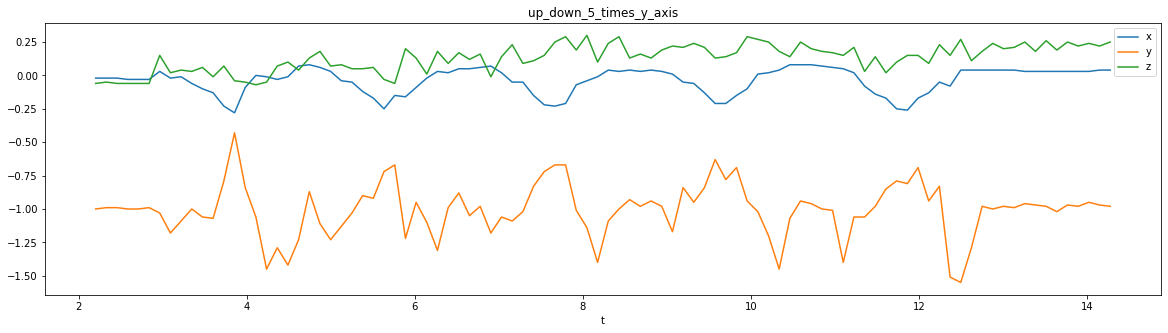

Loaded up_down_5_times_x_axis with 96 entries.


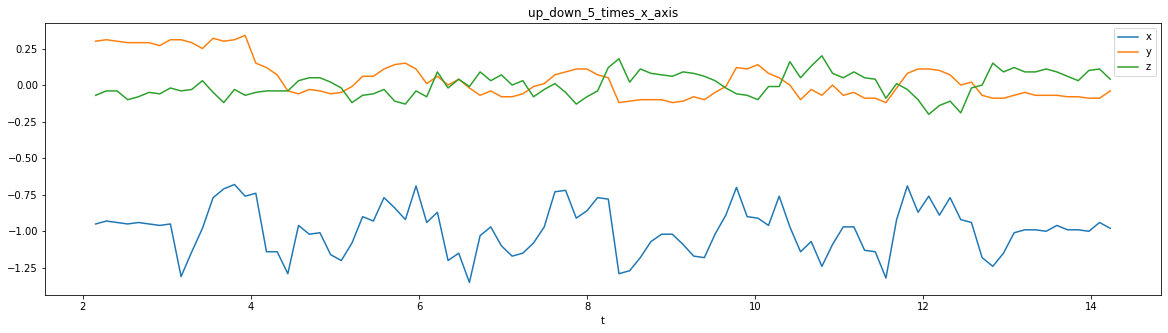

Loaded marching_in_place_right_pocket_10_steps with 96 entries.


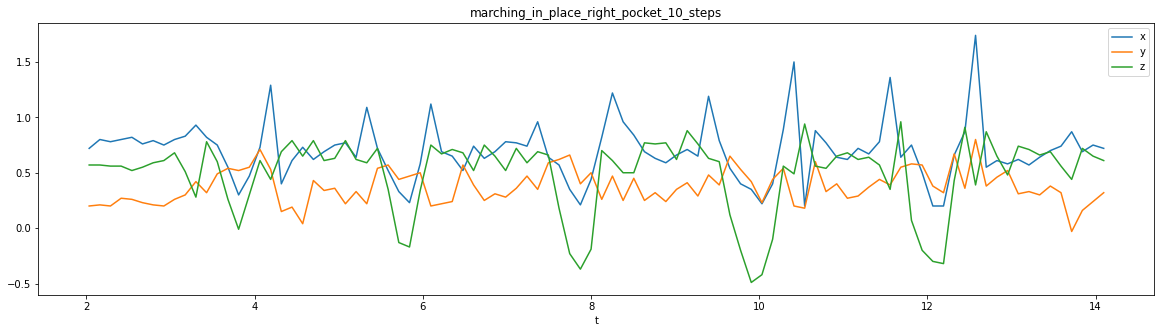

Loaded check_watch_left_hand_5_times with 96 entries.


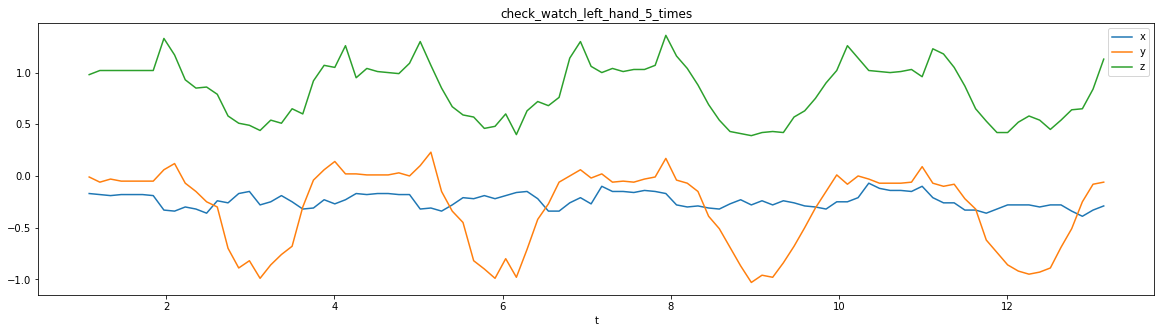

Loaded drop_from_desk_wait_and_pickup with 96 entries.


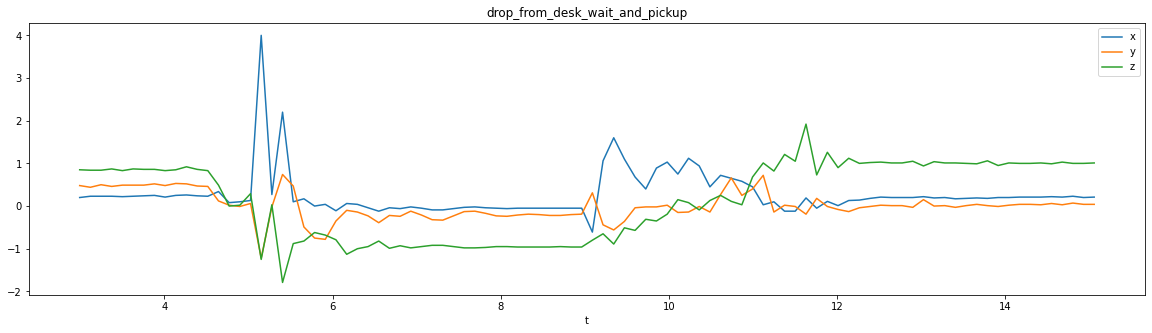

Loaded marching_in_place_left_pocket_10_steps with 96 entries.


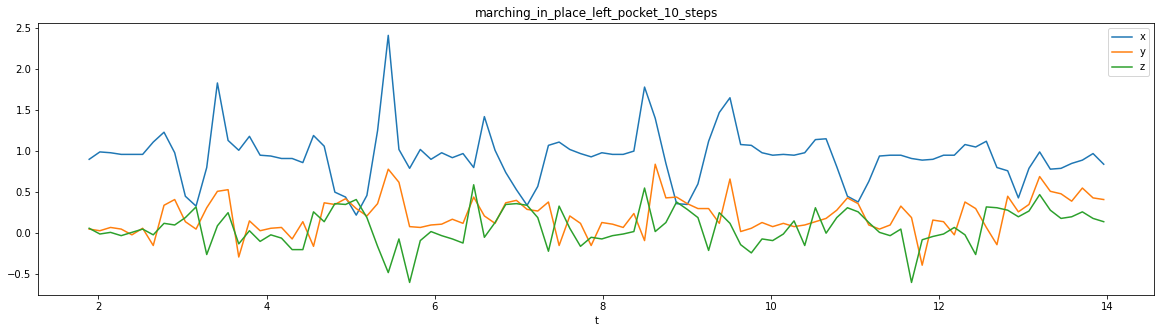

Loaded spin_like_helicopter_propeller_counterclockwise with 96 entries.


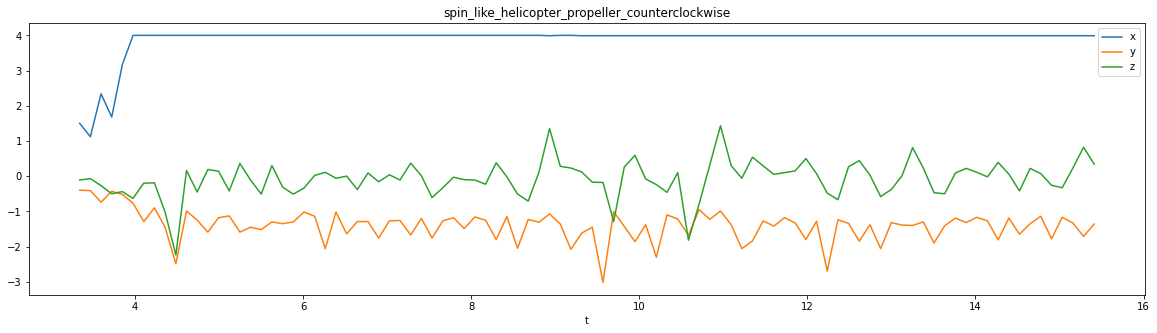

Loaded spin_like_helicopter_propeller_clockwise with 96 entries.


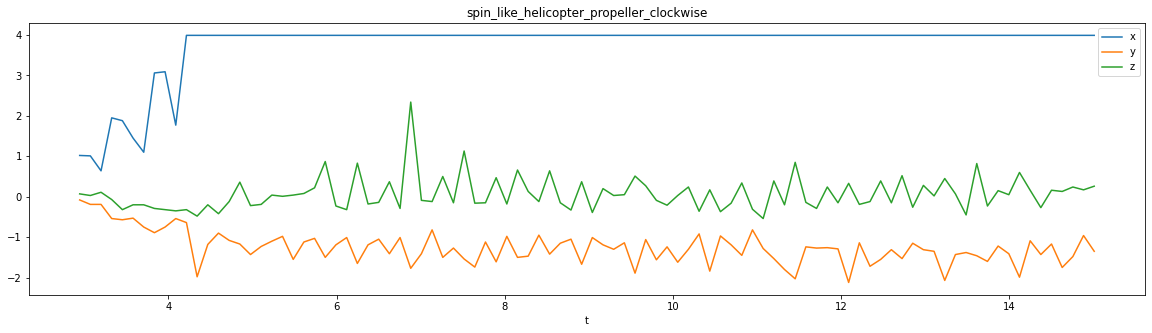

Loaded up_down_5_times_z_axis with 96 entries.


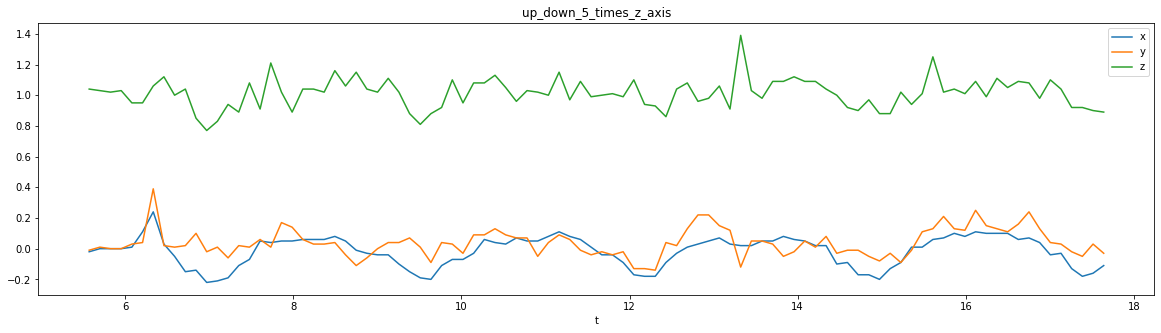

Loaded check_watch_right_hand_5_times with 96 entries.


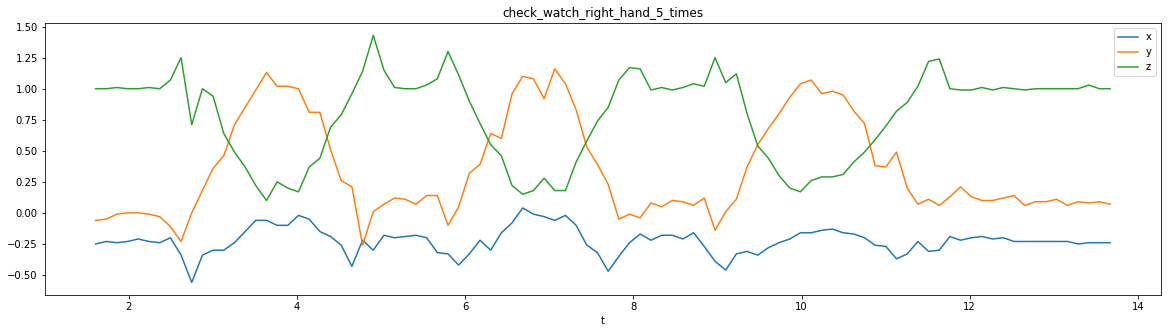

In [260]:
dfs = {} # store offline data dataframes here where key is the name of the file
for fname in os.listdir(data_folder):
    name, ext = os.path.splitext(fname)
    if ext == '.csv':
        dfs[name] = pd.read_csv(data_folder + fname, index_col=0)
        print(f"Loaded {name} with {len(dfs[name])} entries.")
        dfs[name].plot(figsize=(20, 5), title=name)
        plt.show()


        

# Interactive Experiments

In [262]:
#Connect the Arduino Nano 33 IoT to your computer.  
port = Serial(port=arduino_port, baudrate=arduino_baudrate)
port.flushInput()
port.flushOutput()
# Possible errors: 
# "Resource busy": close the serial window in the Arduino IDE and try again

In [263]:
# https://hvplot.holoviz.org/user_guide/Streaming.html
cols = ['t','x','y','z']
df_example = pd.DataFrame(columns=cols)
df = DataFrame(example=df_example)

In [264]:
#This way will plot as a smooth line
df.hvplot(x='t', backlog=50, kind='line')

# This way will plot each sample as a dot and then connect them with a line.  It's a bit slower?
#df.hvplot(x='t', backlog=50, kind='scatter') * df.hvplot(x='t', backlog=50, kind='line')
# re-run this cell to clear the graph

:DynamicMap   []
   :NdOverlay   [Variable]
      :Curve   [t]   (value)

# Experiment 1: Orientation (3 axes)

In [ ]:
# do some buffering

# Note: buffering this way rather than df appending is faster
# before time to fill, and emitt buffer was ~1s after its around 0.5s

buffer_size = 4 # update every 0.5 seconds 


def unpack_serial_line(line, expected_entries, sep='\t'):
    line = line.decode("utf-8").strip()
    entries = line.split(sep)
    if len(entries) != len(expected_entries):
        print(f"Skipping line: {line}.\n Incorrect number of entries, "
              f"expected {len(expected_entries)}, found {len(entries)}.")
        return False
    for i, entry in enumerate(entries):
        try:
            entries[i] = float(entry)
        except ValueError as e:
            print(f"Skipping line: {line}.\n {e}.")
            return False
    return entries

#for i in range(30): # Option 2: read 30 samples and then stop
while(True): #stream forever.  must use "Kernel" --> "Interrupt" to stop
    buffer = []
    for i in range(buffer_size):
        entries = unpack_serial_line(port.readline(), cols)
        if entries:
            buffer.append(entries)
    df_buffer = pd.DataFrame(buffer, columns=cols)
    df_buffer["t"] /= 1000.# convert from milliseconds to seconds
    df.emit(df_buffer)



# Experiment 2: Acceleration, Velocity, and position (single axis)

In [228]:
# https://hvplot.holoviz.org/user_guide/Streaming.html
cols = ['t','x_acc','x_vel','x_pos']
df_example = pd.DataFrame(columns=cols)
df = DataFrame(example=df_example)

In [ ]:
# do some buffering
buffer_size = 4 # update every 0.5 seconds 
while(True): #stream forever.  must use "Kernel" --> "Interrupt" to stop
    try:
        df_buffer = pd.DataFrame(columns=cols)
        for i in range(buffer_size):
            line = port.readline().decode("utf-8")
            t, x, y, z = [float(axis) for axis in line.strip().split("\t")]
            t = t/1000. #convert from milliseconds to seconds
            # print("t={0} x={1} y={2} z={3}".format(t,x,y,z))
            df_buffer = df_buffer.append(pd.DataFrame([[t,x,y,z]], columns=cols))
        #print(df_buffer)
        df.emit(df_buffer)
        #TODO: speed things up by reading out 1s of samples (5-10?) and emitting them all at once
    except Exception as err:
        #skip over the header lines
        print("Could not parse line: " + line)
        print(err)

In [45]:
# First do an offline demo to explain how acceleration, velocity, and position are related
x_accel = [0, 0, 0.25, 0.5, 0.5, 0.25, 0, -0.25, -0.5, -0.5,-0.25, 0]
t = np.arange(len(x_accel))
x_vel = []
x_pos = []
# Initial conditions - optional to discuss.  The accel can only measure change in velocity, 
# but we need need to know the orignal velocity and position were to start 
x_vel.append(0) # x_vel[0]
x_pos.append(0) # x_pos[0]
x_pos.append(0) # x_pos[1]

# Velocity is the integral of acceleration (or acceleration is the derrivative (change in) of velocity)
# We "add up" the accelerometer value over time
for i in range(1, len(x_accel)):
    x_vel.append(x_accel[i] + x_vel[i-1])
    
# Position is the integral of velocity (and double integral of acceleration).  Velocity is the derrivative of position
for j in range(2, len(x_accel)):
    x_pos.append(x_vel[j]+x_pos[j-1])
    

Text(0, 0.5, 'position')

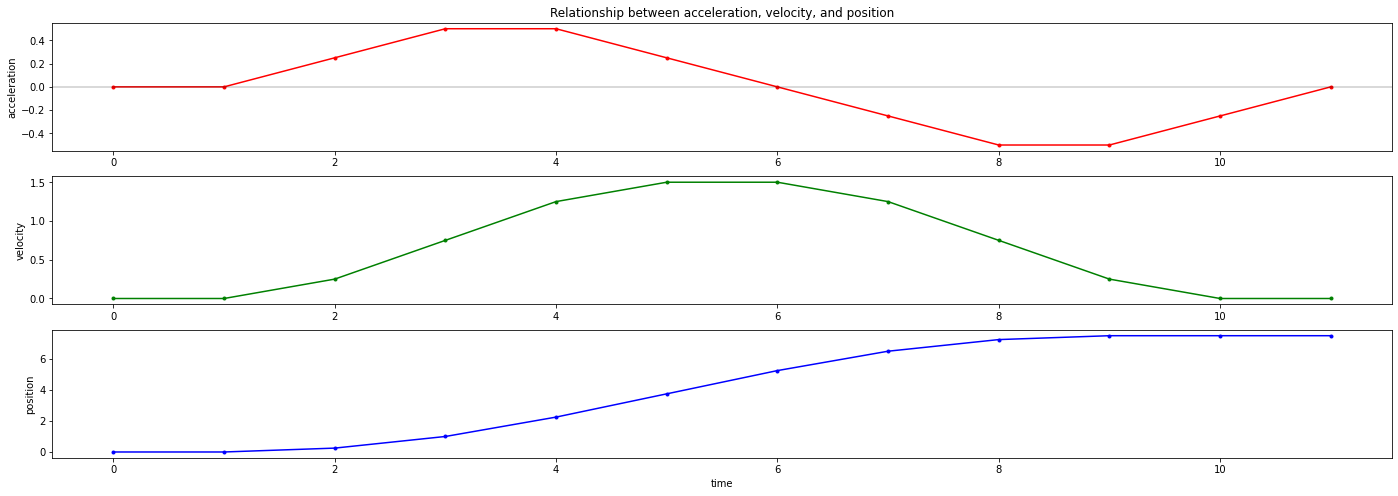

In [44]:
# Plot accel, velocity, and position to show how an accel can be used for "dead-reckoning" tracking
plt.figure(figsize=[24,8])
plt.subplot(3,1,1)
plt.plot(t, x_accel,'r.-',label='acceleration')
xlim =plt.xlim() # save the xlimits
plt.plot([t[0]-1,t[-1]+1], [x_accel[0], x_accel[-1]], 'k-', alpha=0.2) # plot zero-crossing line
plt.xlim(xlim) # restore xlim (lims auto expanded by zero-crossing line)
plt.ylabel("acceleration")
plt.title("Relationship between acceleration, velocity, and position")
plt.subplot(3,1,2)
plt.plot(t, x_vel,'g.-',label='velocity')
plt.ylabel("velocity")
plt.subplot(3,1,3)
plt.plot(t, x_pos,'b.-',label='position')
plt.xlabel('time')
plt.ylabel("position")


In [ ]:
# Now let's use these equations with our accelerometer sensor to estimate the velocity and position of an object.